In [ ]:
import dask.dataframe as dd
from dask.distributed import Client
import xgboost as xgb
import pandas as pd
import os
import logging
import argparse

def parse_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser(description="Apply Dask-trained XGBoost model to a new network")
    parser.add_argument("--output_dir", type=str, required=True, help="Directory to save predictions")
    parser.add_argument("--model", type=str, required=True, help="Path to trained XGBoost .json Booster model")
    parser.add_argument("--target", type=str, required=True, help="Path to .parquet file for inference")
    parser.add_argument("--save_name", type=str, required=True, help="Filename for output")
    return parser.parse_args()

def read_inferred_network(inferred_network_file: str) -> dd.DataFrame:
    """
    Loads a melted sparse inferred network from Parquet and pivots it into a Dask DataFrame
    where each row is (source_id, target_id) and columns are score_types (mean-aggregated).
    """
    logging.info(f"Loading melted sparse network from: {inferred_network_file}")
    melted_ddf = dd.read_parquet(inferred_network_file, engine="pyarrow")

    # Standardize IDs
    melted_ddf["source_id"] = melted_ddf["source_id"].str.upper()
    melted_ddf["target_id"] = melted_ddf["target_id"].str.upper()

    # Aggregate scores
    grouped_ddf = (
        melted_ddf
        .groupby(["source_id", "peak_id", "target_id", "score_type"])["score_value"]
        .mean()
        .reset_index()
    )

    # Pivot manually by converting to pandas (if dataset is small enough)
    def pivot_partition(df):
        return df.pivot_table(
            index=["source_id", "peak_id", "target_id"],
            columns="score_type",
            values="score_value",
            aggfunc="first"
        ).reset_index()

    # Apply pivot in a single partition (best if you've already aggregated)
    pivot_df = grouped_ddf.compute()  # convert to Pandas here
    pivot_df = pivot_partition(pivot_df)
    return dd.from_pandas(pivot_df, npartitions=1)

def main():
    args = parse_args()

    model_path = args.model
    target_path = args.target
    output_dir = args.output_dir
    save_name = args.save_name

    logging.info("Loading XGBoost Booster")
    booster = xgb.Booster()
    booster.load_model(model_path)

    logging.info("Reading inferred network")
    inferred_dd = read_inferred_network(target_path)
    
    feature_names = booster.feature_names
    
    X_dd = inferred_dd[feature_names]

    logging.info("Converting to DaskDMatrix")
    client = Client()
    dtest = xgb.dask.DaskDMatrix(data=X_dd, feature_names=feature_names, client=client)

    logging.info("Running distributed prediction")
    y_pred = xgb.dask.predict(client=client, model=booster, data=dtest)

    # Convert to pandas (merging Dask DataFrame + Dask array)
    logging.info("Joining predictions back to source-target pairs")
    result_df = inferred_dd[["source_id", "peak_id", "target_id"]].compute()
    result_df["score"] = y_pred.compute()
    result_df = result_df.drop_duplicates()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output_path = os.path.join(output_dir, save_name)
    logging.info(f"Saving to {output_path}")
    result_df.to_csv(output_path, sep="\t", index=False)
    logging.info("Done!")

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO, format="%(message)s")
    main()

usage: ipykernel_launcher.py [-h] --output_dir OUTPUT_DIR --model MODEL
                             --target TARGET --save_name SAVE_NAME
ipykernel_launcher.py: error: the following arguments are required: --output_dir, --model, --target, --save_name


SystemExit: 2

/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import dask.dataframe as dd
from dask.distributed import Client
import xgboost as xgb
import pandas as pd
import os
import logging
import argparse

def read_inferred_network(inferred_network_file: str) -> dd.DataFrame:
    """
    Loads a melted sparse inferred network from Parquet and pivots it into a Dask DataFrame
    where each row is (source_id, target_id) and columns are score_types (mean-aggregated).
    """
    logging.info(f"Loading melted sparse network from: {inferred_network_file}")
    melted_ddf = dd.read_parquet(inferred_network_file, engine="pyarrow")

    # Standardize IDs
    melted_ddf["source_id"] = melted_ddf["source_id"].str.upper()
    melted_ddf["target_id"] = melted_ddf["target_id"].str.upper()

    # Aggregate scores
    grouped_ddf = (
        melted_ddf
        .groupby(["source_id", "peak_id", "target_id", "score_type"])["score_value"]
        .mean()
        .reset_index()
    )

    # Pivot manually by converting to pandas (if dataset is small enough)
    def pivot_partition(df):
        return df.pivot_table(
            index=["source_id", "peak_id", "target_id"],
            columns="score_type",
            values="score_value",
            aggfunc="first"
        ).reset_index()

    # Apply pivot in a single partition (best if you've already aggregated)
    pivot_df = grouped_ddf.compute()  # convert to Pandas here
    pivot_df = pivot_partition(pivot_df)
    return dd.from_pandas(pivot_df, npartitions=1)

model_path = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/DS011_mESC/DS011_mESC_sample1_old/trained_models/xgb_DS011_mESC_sample1_old_model.json"
target_path = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/mESC/filtered_L2_E7.5_rep2_old/inferred_grns/inferred_score_df.parquet"
output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/DS011_mESC/DS011_mESC_sample1_old/model_predictions"
save_name = "testing_aggregation_predictions.tsv"


In [ ]:
logging.info("Loading XGBoost Booster")
booster = xgb.Booster()
booster.load_model(model_path)

Loading XGBoost Booster


In [ ]:
logging.info("Reading inferred network")
inferred_dd = read_inferred_network(target_path)

Reading inferred network
Loading melted sparse network from: /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/mESC/filtered_L2_E7.5_rep2_old/inferred_grns/inferred_score_df.parquet
Loading melted sparse network from: /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/mESC/filtered_L2_E7.5_rep2_old/inferred_grns/inferred_score_df.parquet


In [ ]:
feature_names = booster.feature_names

In [ ]:
feature_names

['mean_TF_expression',
 'mean_peak_accessibility',
 'mean_TG_expression',
 'cicero_score',
 'TSS_dist_score',
 'correlation',
 'homer_binding_score',
 'sliding_window_score',
 'string_combined_score',
 'string_experimental_score',
 'string_textmining_score']

In [ ]:
X_dd = inferred_dd[feature_names]

In [ ]:
logging.info("Converting to DaskDMatrix")
client = Client()
dtest = xgb.dask.DaskDMatrix(data=X_dd, feature_names=feature_names, client=client)

Converting to DaskDMatrix
/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 747.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025-06-06 15:06:28,762 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:32971' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'dict-e203242b-90e0-4185-90a9-3f11fef8e217', 'dispatched_predict-7094700feb9f92b5456b23fda250cf16'} (stimulus_id='handle-worker-cleanup-1749236788.7620797')


In [ ]:
logging.info("Running distributed prediction")
y_pred = xgb.dask.predict(client=client, model=booster, data=dtest)

Running distributed prediction


In [ ]:
y_pred

dask.array<from-value, shape=(5420215,), dtype=float32, chunksize=(5420215,), chunktype=numpy.ndarray>

In [ ]:
# Convert to pandas (merging Dask DataFrame + Dask array)
logging.info("Joining predictions back to source-target pairs")
result_df = inferred_dd[["source_id", "peak_id", "target_id"]].compute()
result_df["score"] = y_pred.compute()
result_df = result_df.drop_duplicates()

Joining predictions back to source-target pairs
/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 292.60 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
result_df

score_type,source_id,peak_id,target_id,score
0,AHCTF1,chr10:110317230-110317830,NAP1L1,0.125052
1,AHCTF1,chr10:110534362-110534962,NAP1L1,0.142261
2,AHCTF1,chr10:110600132-110600732,NAP1L1,0.153640
3,AHCTF1,chr10:110782584-110783184,NAP1L1,0.125052
4,AHCTF1,chr10:110794392-110794992,NAP1L1,0.153640
...,...,...,...,...
5420210,ZZZ3,chrX:99853079-99853679,OGT,0.535019
5420211,ZZZ3,chrX:99853079-99853679,TAF1,0.513381
5420212,ZZZ3,chrX:99959435-99960035,OGT,0.451607
5420213,ZZZ3,chrX:99959435-99960035,SLC23A1,0.220922


In [ ]:
tf_tg_edge_groups = result_df.groupby(["source_id", "target_id"])["peak_id"]

In [ ]:
tf_tg_edge_mean_peak_scores = tf_tg_edge_groups.count()



In [ ]:
tf_tg_edge_mean_peak_scores

source_id  target_id    
AHCTF1     9530068E07RIK    15
           AAAS             13
           ABCE1            14
           ACTL6A           11
           ADNP2             6
                            ..
ZZZ3       ZMYM5            19
           ZMYND8            5
           ZNHIT6           11
           ZPR1             13
           ZSWIM2            4
Name: peak_id, Length: 224552, dtype: int64

In [ ]:
tf_tg_edge_scores = result_df.groupby(["source_id", "target_id"])["score"]

In [ ]:
tf_tg_mean_scores = tf_tg_edge_scores.mean()

In [ ]:
tf_tg_mean_scores

source_id  target_id    
AHCTF1     9530068E07RIK    0.070036
           AAAS             0.204600
           ABCE1            0.136525
           ACTL6A           0.141828
           ADNP2            0.090490
                              ...   
ZZZ3       ZMYM5            0.290335
           ZMYND8           0.430185
           ZNHIT6           0.246743
           ZPR1             0.393164
           ZSWIM2           0.001484
Name: score, Length: 224552, dtype: float32

In [ ]:

def read_ground_truth(ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, sep='\t', quoting=csv.QUOTE_NONE, on_bad_lines='skip', header=0)
    ground_truth = ground_truth.rename(columns={"Source": "source_id", "Target": "target_id"})
    return ground_truth

def label_edges_with_ground_truth(inferred_network_dd, ground_truth_df):
    import dask.dataframe as dd
    import numpy as np
    ground_truth_pairs = set(zip(
        ground_truth_df["source_id"].str.upper(),
        ground_truth_df["target_id"].str.upper()
    ))
    
    inferred_network_dd["source_id"] = inferred_network_dd["source_id"].str.upper()
    inferred_network_dd["target_id"] = inferred_network_dd["target_id"].str.upper()


    def label_partition(df):
        df = df.copy()
        tf_tg_tuples = list(zip(df["source_id"], df["target_id"]))
        df.loc[:, "label"] = [1 if pair in ground_truth_pairs else 0 for pair in tf_tg_tuples]
        return df

    inferred_network_dd = inferred_network_dd.map_partitions(
        label_partition,
        meta=inferred_network_dd._meta.assign(label=np.int64(0))
    )

    return inferred_network_dd

ground_truth_file = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN111_ChIPSeq_BEELINE_Mouse_ESC.tsv"



In [ ]:
import csv

In [ ]:
ground_truth_df = read_ground_truth(ground_truth_file)

In [ ]:
tf_tg_mean_scores.reset_index()

,source_id,target_id,score
0,AHCTF1,9530068E07RIK,0.070036
1,AHCTF1,AAAS,0.204600
2,AHCTF1,ABCE1,0.136525
3,AHCTF1,ACTL6A,0.141828
4,AHCTF1,ADNP2,0.090490
...,...,...,...
224547,ZZZ3,ZMYM5,0.290335
224548,ZZZ3,ZMYND8,0.430185
224549,ZZZ3,ZNHIT6,0.246743
224550,ZZZ3,ZPR1,0.393164


In [ ]:
def label_edges_with_ground_truth(inferred_network_dd, ground_truth_df):
    import dask.dataframe as dd
    import numpy as np
    ground_truth_pairs = set(zip(
        ground_truth_df["source_id"].str.upper(),
        ground_truth_df["target_id"].str.upper()
    ))
    
    inferred_network_dd["source_id"] = inferred_network_dd["source_id"].str.upper()
    inferred_network_dd["target_id"] = inferred_network_dd["target_id"].str.upper()


    def label_partition(df):
        df = df.copy()
        tf_tg_tuples = list(zip(df["source_id"], df["target_id"]))
        df.loc[:, "label"] = [1 if pair in ground_truth_pairs else 0 for pair in tf_tg_tuples]
        return df

    inferred_network_dd = inferred_network_dd.apply(
        label_partition,
    )

    return inferred_network_dd

In [ ]:
tf_tg_mean_scores = tf_tg_edge_scores.mean()

In [ ]:
tf_tg_mean_scores = tf_tg_mean_scores.reset_index()

In [ ]:
tf_tg_mean_scores

,source_id,target_id,score
0,AHCTF1,9530068E07RIK,0.070036
1,AHCTF1,AAAS,0.204600
2,AHCTF1,ABCE1,0.136525
3,AHCTF1,ACTL6A,0.141828
4,AHCTF1,ADNP2,0.090490
...,...,...,...
224547,ZZZ3,ZMYM5,0.290335
224548,ZZZ3,ZMYND8,0.430185
224549,ZZZ3,ZNHIT6,0.246743
224550,ZZZ3,ZPR1,0.393164


In [ ]:
ground_truth_pairs = set(zip(
    ground_truth_df["source_id"].str.upper(),
    ground_truth_df["target_id"].str.upper()
))

In [ ]:
tf_tg_mean_scores["source_id"] = tf_tg_mean_scores["source_id"].str.upper()
tf_tg_mean_scores["target_id"] = tf_tg_mean_scores["target_id"].str.upper()

In [ ]:
tf_tg_mean_scores["label"] = [1 if pair in ground_truth_pairs else 0 for pair in list(zip(tf_tg_mean_scores["source_id"], tf_tg_mean_scores["target_id"]))]

In [ ]:
tf_tg_mean_scores

,source_id,target_id,score,label
0,AHCTF1,9530068E07RIK,0.070036,0
1,AHCTF1,AAAS,0.204600,0
2,AHCTF1,ABCE1,0.136525,0
3,AHCTF1,ACTL6A,0.141828,0
4,AHCTF1,ADNP2,0.090490,0
...,...,...,...,...
224547,ZZZ3,ZMYM5,0.290335,0
224548,ZZZ3,ZMYND8,0.430185,0
224549,ZZZ3,ZNHIT6,0.246743,0
224550,ZZZ3,ZPR1,0.393164,0


In [ ]:
import random

In [ ]:
true_edges = tf_tg_mean_scores[tf_tg_mean_scores["label"] == 1]
false_edges = tf_tg_mean_scores[tf_tg_mean_scores["label"] == 0]

In [ ]:
from typing import Union

In [ ]:
def convert_true_false_to_string(value: Union[int, str]):
    if type(value) == int:
        if value == 0:
            return "False"
        elif value == 1:
            return "True"
        else:
            raise ValueError(f"Value {value} in the ground truth label columns is not 0 or 1")
    elif type(value) == str:
        return value
    else:
        raise TypeError("Value must be either of type int or str, got %s" % value)
        

tf_tg_mean_scores["label"] = tf_tg_mean_scores["label"].apply(convert_true_false_to_string)
tf_tg_pivoted: pd.DataFrame = tf_tg_mean_scores.pivot(columns="label", values="score")

In [ ]:
n_true = len(tf_tg_mean_scores[tf_tg_mean_scores["label"] == "True"])
n_false = len(tf_tg_mean_scores[tf_tg_mean_scores["label"] == "False"])


In [ ]:
n_false

201575

In [ ]:
n_true

22977

In [ ]:
min_group_count = min(n_false, n_true)

tf_tg_true = tf_tg_mean_scores[tf_tg_mean_scores["label"] == "True"].sample(min_group_count)
tf_tg_false = tf_tg_mean_scores[tf_tg_mean_scores["label"] == "False"].sample(min_group_count)

tf_tg_balanced = pd.concat([tf_tg_true, tf_tg_false])

In [ ]:
len(tf_tg_balanced[tf_tg_balanced["label"] == "False"])

22977

In [ ]:
len(tf_tg_balanced[tf_tg_balanced["label"] == "True"])

22977

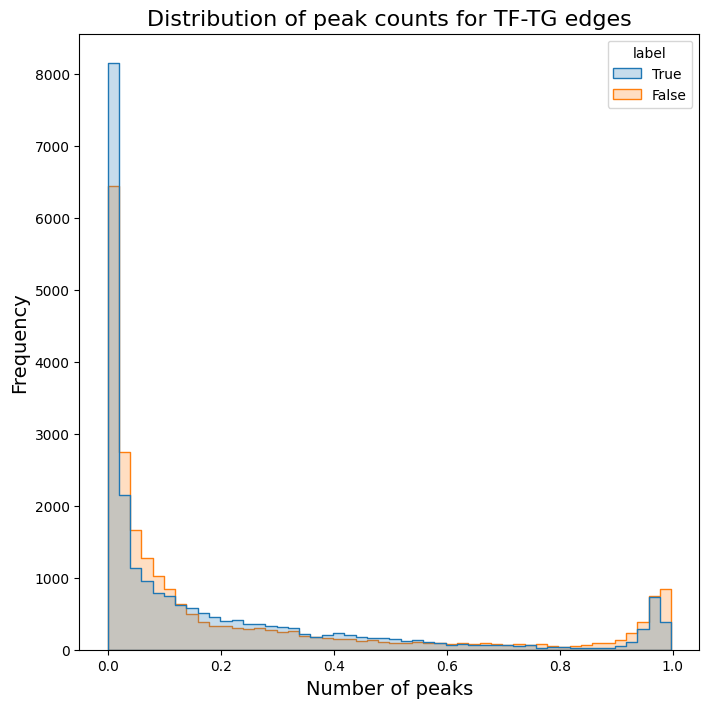

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.histplot(data=tf_tg_balanced, x="score", hue="label", bins=50, element="step", stat="count")
plt.title("Distribution of peak counts for TF-TG edges", fontsize=16)
plt.xlabel("Number of peaks", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

In [ ]:
tf_tg_balanced

,source_id,target_id,score,label
135326,POU5F1,ATG5,0.199159,True
87749,KDM2B,HSPA4,0.022224,True
61539,GATA4,KRAS,0.731106,True
214459,ZFP281,CEP192,0.025787,True
187393,TET1,SETDB2,0.052310,True
...,...,...,...,...
125156,NPAS4,OTX2,0.955253,False
131576,PBX3,OTX2,0.313719,False
110477,MSX1,MUC1,0.000045,False
81197,IRF3,TCF7L1,0.129048,False


In [ ]:
tf_tg_edge_scores

In [ ]:
tf_tg_edge_scores.count()

source_id  target_id    
AHCTF1     9530068E07RIK    15
           AAAS             13
           ABCE1            14
           ACTL6A           11
           ADNP2             6
                            ..
ZZZ3       ZMYM5            19
           ZMYND8            5
           ZNHIT6           11
           ZPR1             13
           ZSWIM2            4
Name: score, Length: 224552, dtype: int64

In [ ]:
tf_tg_edge_scores.count().reset_index()

,source_id,target_id,score
0,AHCTF1,9530068E07RIK,15
1,AHCTF1,AAAS,13
2,AHCTF1,ABCE1,14
3,AHCTF1,ACTL6A,11
4,AHCTF1,ADNP2,6
...,...,...,...
224547,ZZZ3,ZMYM5,19
224548,ZZZ3,ZMYND8,5
224549,ZZZ3,ZNHIT6,11
224550,ZZZ3,ZPR1,13


In [ ]:
tf_tg_edge_count = tf_tg_edge_scores.count().reset_index()
tf_tg_edge_count["label"] = ["True" if pair in ground_truth_pairs else "False" for pair in list(zip(tf_tg_edge_count["source_id"], tf_tg_edge_count["target_id"]))]

In [ ]:
n_true = len(tf_tg_edge_count[tf_tg_edge_count["label"] == "True"])
n_false = len(tf_tg_edge_count[tf_tg_edge_count["label"] == "False"])

min_group_count = min(n_false, n_true)

tf_tg_true = tf_tg_edge_count[tf_tg_edge_count["label"] == "True"].sample(min_group_count)
tf_tg_false = tf_tg_edge_count[tf_tg_edge_count["label"] == "False"].sample(min_group_count)

tf_tg_count_balanced = pd.concat([tf_tg_true, tf_tg_false])

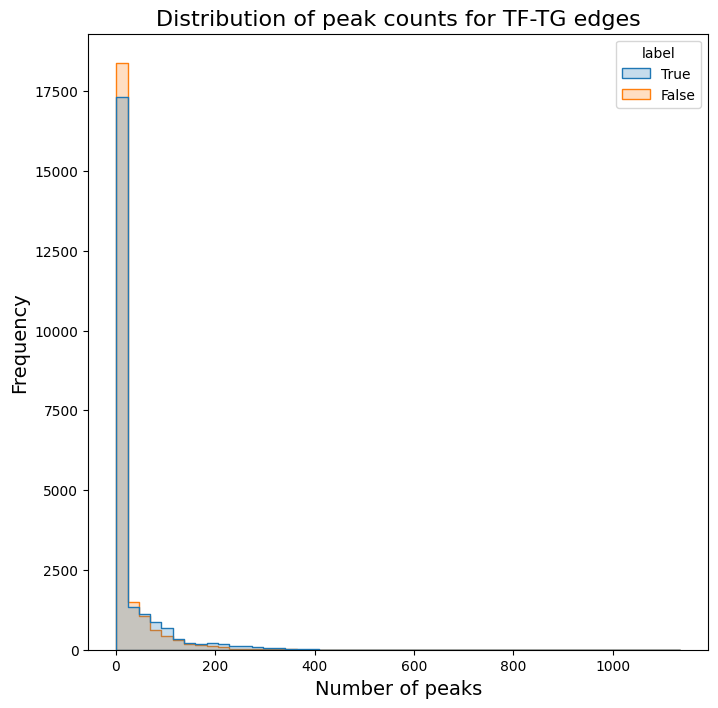

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.histplot(data=tf_tg_count_balanced, x="score", hue="label", bins=50, element="step", stat="count")
plt.title("Distribution of peak counts for TF-TG edges", fontsize=16)
plt.xlabel("Number of peaks", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

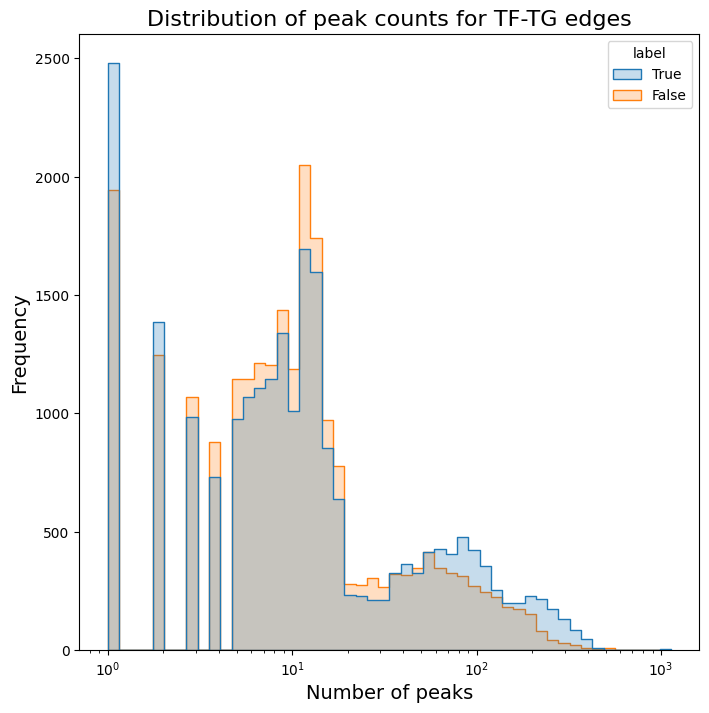

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.histplot(data=tf_tg_count_balanced, x="score", hue="label", log_scale=True, bins=50, element="step", stat="count")
plt.title("Distribution of peak counts for TF-TG edges", fontsize=16)
plt.xlabel("Number of peaks", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

In [ ]:
inferred_df = pd.read_parquet(target_path, engine="pyarrow")

In [ ]:
inferred_df

,source_id,peak_id,target_id,score_type,score_value
0,Gli2,chr11:80062014-80062614,Suz12,sliding_window_score,0.535918
1,Trp53,chr19:46223020-46223620,As3mt,sliding_window_score,0.820166
2,Runx1,chr3:95194969-95195569,Arnt,sliding_window_score,0.527844
3,Zeb2,chr2:139906313-139906913,Fli1,sliding_window_score,0.653707
4,Kdm2b,chr8:85857079-85857679,Nacc1,sliding_window_score,0.464758
...,...,...,...,...,...
41612701,Klf4,chr16:32611969-32612569,Tfrc,string_combined_score,0.228683
41612702,Smad3,chr4:134473617-134474217,Stmn1,string_combined_score,0.415886
41612703,Jund,chr4:86725067-86725667,Mllt3,string_combined_score,0.114171
41612704,Sox6,chr14:99616849-99617449,Klf12,string_combined_score,0.547130


In [ ]:
# Aggregate scores
grouped_ddf = (
    inferred_df
    .groupby(["source_id", "peak_id", "target_id", "score_type"])["score_value"]
    .mean()
    .reset_index()
)

# Pivot manually by converting to pandas (if dataset is small enough)
def pivot_partition(df):
    return df.pivot_table(
        index=["source_id", "peak_id", "target_id"],
        columns="score_type",
        values="score_value",
        aggfunc="first"
    ).reset_index()
inferred_df_full = pivot_partition(grouped_ddf)

In [ ]:
def aggregate_tf_tg_score(peak_scores):
    return np.percentile(peak_scores, 75)

def softmax_weighted_average(peak_scores, lambda_=5.0):
    weights = np.exp(lambda_ * peak_scores)
    return np.sum(weights * peak_scores) / np.sum(weights)

In [ ]:
print(result_df.head())

score_type source_id                    peak_id target_id     score
0             AHCTF1  chr10:110317230-110317830    NAP1L1  0.125052
1             AHCTF1  chr10:110534362-110534962    NAP1L1  0.142261
2             AHCTF1  chr10:110600132-110600732    NAP1L1  0.153640
3             AHCTF1  chr10:110782584-110783184    NAP1L1  0.125052
4             AHCTF1  chr10:110794392-110794992    NAP1L1  0.153640


In [ ]:
threshold = 0.5
agg_df = result_df.groupby(["source_id", "target_id"])["score"].agg(
    tf_tg_score_75pct = lambda x: np.percentile(x, 75),
    tf_tg_score_softmax = lambda x: softmax_weighted_average(x, lambda_=5.0),
    tf_tg_frac_high = lambda x: np.mean(x > threshold)
).reset_index()

Task exception was never retrieved
future: <Task finished name='Task-473528' coro=<Client._gather.<locals>.wait() done, defined at /gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/distributed/client.py:2396> exception=AllExit()>
Traceback (most recent call last):
  File "/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/distributed/client.py", line 2405, in wait
    raise AllExit()
distributed.client.AllExit


In [ ]:
agg_df

,source_id,target_id,tf_tg_score_75pct,tf_tg_score_softmax,tf_tg_frac_high
0,AHCTF1,9530068E07RIK,0.068897,0.070101,0.0
1,AHCTF1,AAAS,0.227423,0.208027,0.0
2,AHCTF1,ABCE1,0.138652,0.136594,0.0
3,AHCTF1,ACTL6A,0.142602,0.141882,0.0
4,AHCTF1,ADNP2,0.090607,0.090490,0.0
...,...,...,...,...,...
224547,ZZZ3,ZMYM5,0.287492,0.290926,0.0
224548,ZZZ3,ZMYND8,0.446084,0.432690,0.0
224549,ZZZ3,ZNHIT6,0.247404,0.248302,0.0
224550,ZZZ3,ZPR1,0.407686,0.395201,0.0


In [ ]:
agg_df["label"] = ["True" if pair in ground_truth_pairs else "False" for pair in list(zip(agg_df["source_id"], agg_df["target_id"]))]

In [ ]:
n_true = len(agg_df[agg_df["label"] == "True"])
n_false = len(agg_df[agg_df["label"] == "False"])

min_group_count = min(n_false, n_true)

tf_tg_true = agg_df[agg_df["label"] == "True"].sample(min_group_count)
tf_tg_false = agg_df[agg_df["label"] == "False"].sample(min_group_count)

tf_tg_count_balanced = pd.concat([tf_tg_true, tf_tg_false])